In [1]:
pip install scipy pandas


Note: you may need to restart the kernel to use updated packages.


### Load and Preview Trust Matrix
This section loads the trust matrix from a .mat file and converts it to a pandas DataFrame.


In [2]:
from scipy.io import loadmat
import pandas as pd

# Replace with your full file path
mat_file_path = "trust.mat"

# Load the .mat file
mat_contents = loadmat(mat_file_path)

# Check available keys in the .mat file
print(mat_contents.keys())

# Extract the 'trust' array from the loaded .mat file
trust_data = mat_contents['trust']

# Convert it into a DataFrame
df = pd.DataFrame(trust_data)

# Preview the first few rows
print(df.head())
print("Shape of dataset:", df.shape)


dict_keys(['__header__', '__version__', '__globals__', 'trust'])
      0      1
0  9831  19832
1  9831   4247
2  9831   7375
3  9831  15698
4  9831   8604
Shape of dataset: (355813, 2)


In [3]:
from scipy.io import loadmat

# Replace this with the path to your other MATLAB file
mat_file_path = "rating_with_timestamp.mat"

mat_contents = loadmat(mat_file_path)

# List all keys in the .mat file
print(mat_contents.keys())

# Extract the dataset
rating_data = mat_contents['rating_with_timestamp']

# Convert to DataFrame
df_rating = pd.DataFrame(rating_data)

# Preview structure
print(df_rating.head())
print("Shape:", df_rating.shape)


dict_keys(['__header__', '__version__', '__globals__', 'rating_with_timestamp'])
   0  1  2  3  4          5
0  1  1  3  2  2  973234800
1  1  2  2  2  3  972025200
2  1  3  3  2  1  971593200
3  1  4  3  5  2  966668400
4  1  5  3  3  2  963471600
Shape: (922267, 6)


### Clean, Merge, and Aggregate Trust-Rating Data

This block performs the foundational preprocessing required to combine trust network structure with user-generated rating behavior. The steps include:

#### 🧹 Column Renaming
The rating dataset initially uses generic or ambiguous column names such as `userid`, `rating`, and `helpfulness`. These are renamed for clarity and alignment with trust modeling terminology:
- `userid` → `trustor` (the user giving the rating)
- `rating` → `PDR` (Perceived Direct Rating; proxy for trust level)
- `helpfulness` → `confidence` (used as a proxy for certainty in the rating)

#### 🕒 Timestamp Conversion
Timestamps are originally UNIX-encoded (`int64`). They're converted into `datetime` objects using:
```python
df_rating['timestamp'] = pd.to_datetime(df_rating['timestamp'], unit='s')


In [4]:
# Reuse 'df' as df_trust with correct column names
df_trust = df.copy()
df_trust.columns = ['trustor', 'trustee']

# Rename rating columns
df_rating.columns = ['userid', 'productid', 'categoryid', 'rating', 'helpfulness', 'timestamp']
df_rating.rename(columns={
    'userid': 'trustor',
    'rating': 'PDR',
    'helpfulness': 'confidence'
}, inplace=True)

# Convert timestamp
df_rating['timestamp'] = pd.to_datetime(df_rating['timestamp'], unit='s')

# Merge trust and rating data on 'trustor'
df_merged = pd.merge(df_trust, df_rating, on='trustor')
df_merged = df_merged[['trustor', 'trustee', 'productid', 'categoryid', 'PDR', 'confidence', 'timestamp']]

# Aggregate by trustor–trustee
df_trust_enriched = df_merged.groupby(['trustor', 'trustee']).agg({
    'PDR': 'mean',
    'confidence': 'mean',
    'timestamp': 'min',
    'categoryid': 'first'
}).reset_index()

print("✅ Trustor–Trustee enriched dataset created:")
print(df_trust_enriched.head())


✅ Trustor–Trustee enriched dataset created:
   trustor  trustee      PDR  confidence           timestamp  categoryid
0        2      829  3.71875     1.65625 2000-01-25 07:00:00           3
1        2     3463  3.71875     1.65625 2000-01-25 07:00:00           3
2        2     4114  3.71875     1.65625 2000-01-25 07:00:00           3
3        2     6339  3.71875     1.65625 2000-01-25 07:00:00           3
4        2     7336  3.71875     1.65625 2000-01-25 07:00:00           3


### Dataset Diagnostics and Deduplication

This block performs essential data quality checks on the `df_trust_enriched` dataset, which combines both trust relationships and behavioral trust metrics. The goal is to ensure that the dataset is clean, consistent, and free from structural redundancies before proceeding with modeling or analysis.

#### 🧾 Diagnostic Checks

1. **Dataset Shape**:
   Reports the number of rows and columns to verify expected size after merging and aggregation.

2. **Column Data Types**:
   Ensures that numerical trust features (`PDR`, `confidence`, `friendshipness`, etc.) are correctly interpreted as `float64` or `int64`, and that `timestamp` is in `datetime64`.

3. **Missing Value Check**:
   Displays the count of `NaN` values in each column using:
   ```python
   df_trust_enriched.isnull().sum()


In [5]:
print("Shape of dataset:", df_trust_enriched.shape)
print("\nColumn Data Types:\n", df_trust_enriched.dtypes)
print("\nMissing Values per Column:\n", df_trust_enriched.isnull().sum())
print("\nAny NA in rating data?:", df_rating.isna().values.any())

# Check and drop duplicates
duplicates = df_trust_enriched.duplicated()
print(f"\nNumber of duplicate rows: {duplicates.sum()}")
df_trust_enriched.drop_duplicates(inplace=True)
print("New shape after dropping duplicates:", df_trust_enriched.shape)

# Show head
df_trust_enriched.head()


Shape of dataset: (355168, 6)

Column Data Types:
 trustor               uint64
trustee               uint64
PDR                  float64
confidence           float64
timestamp     datetime64[ns]
categoryid             int32
dtype: object

Missing Values per Column:
 trustor       0
trustee       0
PDR           0
confidence    0
timestamp     0
categoryid    0
dtype: int64

Any NA in rating data?: False

Number of duplicate rows: 0
New shape after dropping duplicates: (355168, 6)


,trustor,trustee,PDR,confidence,timestamp,categoryid
0,2,829,3.71875,1.65625,2000-01-25 07:00:00,3
1,2,3463,3.71875,1.65625,2000-01-25 07:00:00,3
2,2,4114,3.71875,1.65625,2000-01-25 07:00:00,3
3,2,6339,3.71875,1.65625,2000-01-25 07:00:00,3
4,2,7336,3.71875,1.65625,2000-01-25 07:00:00,3


### Calculate Friendshipness (Feature Engineering)

This block creates a new trust feature called `friendshipness`, which represents the **structural closeness** between a trustor and trustee based on their shared social network within the trust graph.

#### 🧠 Concept
The idea behind friendshipness is simple but powerful: if two users (a trustor and a trustee) share many **mutual trusted connections**, they are likely to be socially closer — and their trust relationship is more trustworthy or organic.

This mirrors real-world logic where friends of friends are more likely to be trustworthy due to shared reputation or context.

#### ⚙️ Calculation Steps

1. **Build Trust Graph Dictionary**:
   A dictionary `friend_dict` is created using:
   ```python
   friend_dict[row['trustor']].add(row['trustee'])


In [6]:
from collections import defaultdict

# Step 1: Build a dictionary mapping each trustor to the trustees they trust (from df_trust_enriched)
friend_dict = defaultdict(set)

for _, row in df_trust_enriched.iterrows():
    friend_dict[row['trustor']].add(row['trustee'])

# Step 2: Define the friendshipness function
def compute_friendshipness(row):
    a = row['trustor']
    b = row['trustee']
    
    friends_a = friend_dict.get(a, set())
    friends_b = friend_dict.get(b, set())

    if not friends_a or not friends_b:
        return 0.0

    common = friends_a & friends_b
    total = friends_a | friends_b

    return len(common) / len(total) if total else 0.0

# Step 3: Apply to df_trust_enriched
df_trust_enriched['friendshipness'] = df_trust_enriched.apply(compute_friendshipness, axis=1)

print("✅ Friendshipness successfully added to df_trust_enriched.")


✅ Friendshipness successfully added to df_trust_enriched.


### Assess Friendshipness Values
This code calculates the percentage of rows where the computed friendshipness is zero.


In [7]:
# Count how many rows have zero friendshipness
zero_count = (df_trust_enriched['friendshipness'] == 0).sum()

# Total number of rows
total_rows = df_trust_enriched.shape[0]

# Calculate percentage
percent_zero = (zero_count / total_rows) * 100

# Display result
print(f"🔍 Percentage of rows with zero friendshipness: {percent_zero:.2f}%")


🔍 Percentage of rows with zero friendshipness: 19.24%


### Add Frequency of Interaction

This feature engineering step quantifies the **strength of interaction** between each trustor–trustee pair by counting how many times that specific relationship appears in the dataset. The result is stored in a new column called `interaction_count`.

#### 🔁 Motivation
While a single trust score can offer a snapshot of sentiment, **repeated interactions** between a trustor and trustee indicate:
- Ongoing trust relationships
- Greater relational stability
- Higher confidence in the trust data

Tracking interaction frequency helps detect:
- Over-trusted entities (frequently trusted by the same user)
- One-time spammers (low frequency + high rating)
- Consistent low scorers (low trust + many ratings)

#### ⚙️ Implementation

1. **Group by (trustor, trustee)**:
   ```python
   interaction_counts = df_trust_enriched.groupby(['trustor', 'trustee']).size().reset_index(name='interaction_count')


In [8]:
interaction_counts = df_trust_enriched.groupby(['trustor', 'trustee']).size().reset_index(name='interaction_count')
df_trust_enriched = df_trust_enriched.merge(interaction_counts, on=['trustor', 'trustee'], how='left')

print("✅ Frequency of interaction added to df_trust_enriched.")


✅ Frequency of interaction added to df_trust_enriched.


### Dataset Summary and Statistics

This block performs an in-depth structural and statistical audit of the `df_trust_enriched` dataset to understand the distribution and behavior of key trust-related features. It provides both **descriptive statistics** and **data sanity checks** before feature engineering and modeling.

#### 🔍 Structure Inspection

1. **Shape**:
   - Displays the number of rows and columns to verify dataset size.

2. **Column Names and Types**:
   - Ensures all expected columns exist (e.g., `trustor`, `trustee`, `PDR`, `confidence`, `friendshipness`, `interaction_count`)
   - Confirms that numerical features are of type `float64` or `int64`, and that `timestamp` is `datetime64`.

3. **Missing Values**:
   - Uses `.isnull().sum()` to detect incomplete data.
   - Ensures no propagation of `NaN` values from merge or transformation steps.

4. **Duplicate Count**:
   - Identifies duplicate rows that may have slipped in after merging or enrichment steps.

#### 📊 Descriptive Statistics

The `.describe(include='all')` method is used to provide:
- **Central tendency**: Mean and median of numeric columns
- **Dispersion**: Standard deviation, min/max, and quartiles
- **Cardinality**: Count of unique values (for categorical data)

This summary is especially important for trust modeling because:
- Features like `PDR`, `confidence`, and `friendshipness` are sensitive to skew and outliers.
- Trust scores close to 0 or far above average may indicate edge cases, fraud, or special users.
- Unusual distributions in `interaction_count` may indicate hyperactive or passive users.

#### 📌 Feature Extremes

The code also prints:
```python
for col in ['PDR', 'confidence', 'friendshipness', 'interaction_count']:
    print(f"{col}: min = ..., max = ...")


In [9]:
# === Step 3: General Dataset Exploration ===
print("\n📌 Dataset Shape:", df_trust_enriched.shape)
print("\n📌 Column Names:", df_trust_enriched.columns.tolist())
print("\n📌 Data Types:\n", df_trust_enriched.dtypes)
print("\n📌 Missing Values:\n", df_trust_enriched.isnull().sum())
print("\n📌 Duplicate Rows:", df_trust_enriched.duplicated().sum())

# Descriptive statistics
print("\n📌 Descriptive Statistics:")
print(df_trust_enriched.describe(include='all'))

# Number of unique users
print("\n📌 Unique Trustors:", df_trust_enriched['trustor'].nunique())
print("📌 Unique Trustees:", df_trust_enriched['trustee'].nunique())

# Sample preview
print("\n📌 Sample Data:")
print(df_trust_enriched.head())

# Min/max in relevant columns
print("\n🔍 Min/Max values:")
for col in ['PDR', 'confidence', 'friendshipness', 'interaction_count']:
    print(f"{col}: min = {df_trust_enriched[col].min()}, max = {df_trust_enriched[col].max()}")



📌 Dataset Shape: (355168, 8)

📌 Column Names: ['trustor', 'trustee', 'PDR', 'confidence', 'timestamp', 'categoryid', 'friendshipness', 'interaction_count']

📌 Data Types:
 trustor                      uint64
trustee                      uint64
PDR                         float64
confidence                  float64
timestamp            datetime64[ns]
categoryid                    int32
friendshipness              float64
interaction_count             int64
dtype: object

📌 Missing Values:
 trustor              0
trustee              0
PDR                  0
confidence           0
timestamp            0
categoryid           0
friendshipness       0
interaction_count    0
dtype: int64

📌 Duplicate Rows: 0

📌 Descriptive Statistics:
              trustor        trustee            PDR     confidence  \
count   355168.000000  355168.000000  355168.000000  355168.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            Na

C:\Users\banga\AppData\Local\Temp\ipykernel_28400\1174979049.py:10: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df_trust_enriched.describe(include='all'))


### Normalize and Compute Total Trust Score

This block performs feature normalization and derives a composite trust score called `total`, which summarizes multiple dimensions of trust in a single metric. This score is critical for downstream tasks such as anomaly detection, visualization, attack simulation, and sampling.

---

#### ⚖️ Why Normalize?

The dataset contains three key numeric trust metrics:
- `PDR` (Perceived Direct Rating)
- `confidence` (user-reported confidence in rating)
- `friendshipness` (graph-based similarity between trustor and trustee)

These features are on different scales:
- `PDR` typically ranges from 0 to 5
- `confidence` can vary depending on source
- `friendshipness` is bounded between 0 and 1

To ensure fair contribution from each metric, **min-max normalization** is applied:
```python
df_trust_enriched['PDR_normalized'] = df_trust_enriched['PDR'] / df_trust_enriched['PDR'].max()
df_trust_enriched['confidence_normalized'] = df_trust_enriched['confidence'] / df_trust_enriched['confidence'].max()


In [10]:
# Add normalized columns
df_trust_enriched['PDR_normalized'] = df_trust_enriched['PDR'] / df_trust_enriched['PDR'].max()
df_trust_enriched['confidence_normalized'] = df_trust_enriched['confidence'] / df_trust_enriched['confidence'].max()

# Compute total trust score
df_trust_enriched['total'] = (
    df_trust_enriched['PDR_normalized'] + 
    df_trust_enriched['confidence_normalized'] + 
    df_trust_enriched['friendshipness']
)

# Save updated dataset
output_path = "C:/Users/banga/OneDrive/Desktop/Trust_Enriched_With_Score.csv"
df_trust_enriched.to_csv(output_path, index=False)

print("✅ Normalized scores and total added to df_trust_enriched. File saved at:")
print(output_path)


✅ Normalized scores and total added to df_trust_enriched. File saved at:
C:/Users/banga/OneDrive/Desktop/Trust_Enriched_With_Score.csv


### Filter for High-Quality Non-Zero Entries

This step filters out incomplete or unreliable trustor–trustee interactions by retaining only those rows in which **all trust-related metrics** are strictly greater than zero.

---

#### 🎯 Rationale

Zero values in trust metrics may indicate:
- Missing or default-filled data from upstream processes
- Non-informative relationships (e.g., zero `friendshipness` implies no shared trusted connections)
- Low-quality or suspicious entries (e.g., no `confidence`, no `PDR`, or no prior interactions)

Since these zeros dilute the quality of both visual and statistical analyses, they are removed to produce a **high-confidence dataset**.

---

#### ⚙️ Filtering Logic

The condition is applied across all columns:
```python
high_quality_split = df_trust_enriched[(df_trust_enriched != 0).all(axis=1)].copy()


In [11]:
# Keep only rows where all values are non-zero
high_quality_split = df_trust_enriched[(df_trust_enriched != 0).all(axis=1)].copy()

# Print row count
print(f"✅ Number of rows in high_quality_split (no zero entries): {high_quality_split.shape[0]}")

# Save to CSV
output_path = "C:/Users/banga/OneDrive/Desktop/High_Quality_Trust_Split_NonZero.csv"
high_quality_split.to_csv(output_path, index=False)

print(f"✅ high_quality_split saved to: {output_path}")


✅ Number of rows in high_quality_split (no zero entries): 286840
✅ high_quality_split saved to: C:/Users/banga/OneDrive/Desktop/High_Quality_Trust_Split_NonZero.csv


### Stratified Sampling on Trust Features

This step performs **controlled sampling** from the high-quality trust dataset to create a representative subset of user interactions that preserve diversity across key trust dimensions. The goal is to prepare a dataset suitable for experiments or evaluations without introducing bias or skew.

---

#### 🎯 Why Stratified Sampling?

Random sampling might overrepresent common patterns and underrepresent edge cases. Stratified sampling ensures:
- Proportional representation of trust behaviors (high/low scores, consistent/erratic trustors)
- Inclusion of edge scenarios (e.g., medium confidence, average friendshipness, varied PDR)
- Fair distribution across trustor profiles for robust model training or simulation

---

#### 🧮 Stratification Criteria

Each row is assigned to a **stratum** based on a composite label:
```python
strat_label = f"P{int(PDR)}_C{int(confidence)}_F{friendshipness_bucket}"


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Step 1: Start with df_trust_enriched
df_high_quality = df_trust_enriched[
    (df_trust_enriched['confidence'] >= 2) &
    (df_trust_enriched['interaction_count'] >= 1) &
    (df_trust_enriched['friendshipness'] > 0)
].copy()

print("High-quality entries (relaxed):", df_high_quality.shape[0])

# Step 2: Create stratification labels (PDR + Confidence + Friendshipness bucket)
def create_strat_label(row):
    if row['friendshipness'] > 0.7:
        friend_label = 'H'
    elif row['friendshipness'] > 0.3:
        friend_label = 'M'
    else:
        friend_label = 'L'
    return f"P{int(row['PDR'])}_C{int(row['confidence'])}_F{friend_label}"

df_high_quality['strat_label'] = df_high_quality.apply(create_strat_label, axis=1)

# Step 3: Drop rare strata with < 2 samples
label_counts = df_high_quality['strat_label'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
df_high_quality = df_high_quality[df_high_quality['strat_label'].isin(valid_labels)]

print("Remaining rows after dropping rare strat_labels:", df_high_quality.shape[0])

# Step 4: Stratified sampling
stratified_sample, _ = train_test_split(
    df_high_quality,
    stratify=df_high_quality['strat_label'],
    train_size=12000,
    random_state=42
)

print("✅ Stratified trust-based sample shape:", stratified_sample.shape)

# Step 5: Drop helper column and save
stratified_sample.drop(columns=['strat_label'], inplace=True)

output_path = "C:/Users/banga/OneDrive/Desktop/Stratified_Trust_Split.csv"
stratified_sample.to_csv(output_path, index=False)

print(f"📁 Saved stratified trust sample to: {output_path}")


High-quality entries (relaxed): 91106
Remaining rows after dropping rare strat_labels: 91103
✅ Stratified trust-based sample shape: (12000, 12)
📁 Saved stratified trust sample to: C:/Users/banga/OneDrive/Desktop/Stratified_Trust_Split.csv


### Visualize Trust Metrics and Patterns

This section generates three types of visual analytics for exploratory data analysis (EDA) on trust data, applied separately to both:
- The **high-quality non-zero dataset**
- The **stratified trust sample**

These visualizations help validate data distributions, reveal engagement patterns, and expose temporal trust dynamics, all of which are essential for anomaly detection and trust behavior profiling.

---

#### 📊 1. Distribution Plots of Trust Features

A triplet of histograms shows the distribution of:
- **PDR** (Perceived Direct Rating): reflects user sentiment in direct ratings
- **Confidence**: how sure the trustor was when providing the rating
- **Friendshipness**: graph-based structural similarity between trustor and trustee

These plots help you:
- Identify skewness or outliers (e.g., overuse of high confidence scores)
- Validate whether normalization is needed
- Detect unusual rating behavior clusters (e.g., uniformly high PDR with low confidence)

Each feature is plotted using `sns.histplot(..., kde=True)` for smoother visual interpretation.

---

#### 📈 2. Activity Histograms for Trustors and Trustees

Two additional histograms are plotted:
- **Trustor Activity**: how many ratings each user gave
- **Trustee Activity**: how many times each user was rated

These distributions help identify:
- Power users (super trustors)
- Popular or suspicious trustees (e.g., those with unusually high incoming trust)
- Long tails, user clustering, and signs of trust inflation or sybil attacks

---

#### 🗓 3. Monthly Trust Interaction Trends

A bar chart is created by:
1. Converting timestamps to monthly periods using:
   ```python
   df['month'] = df['timestamp'].dt.to_period('M')



📊 Visualizing: Stratified Trust Split


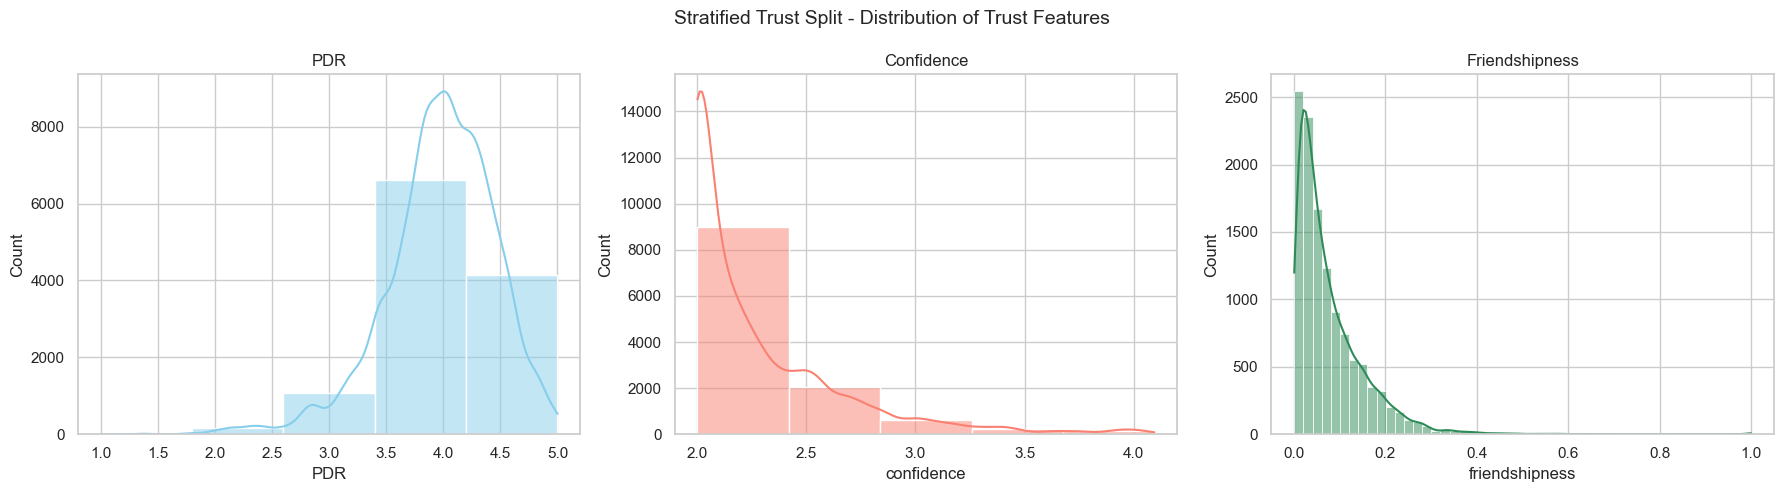

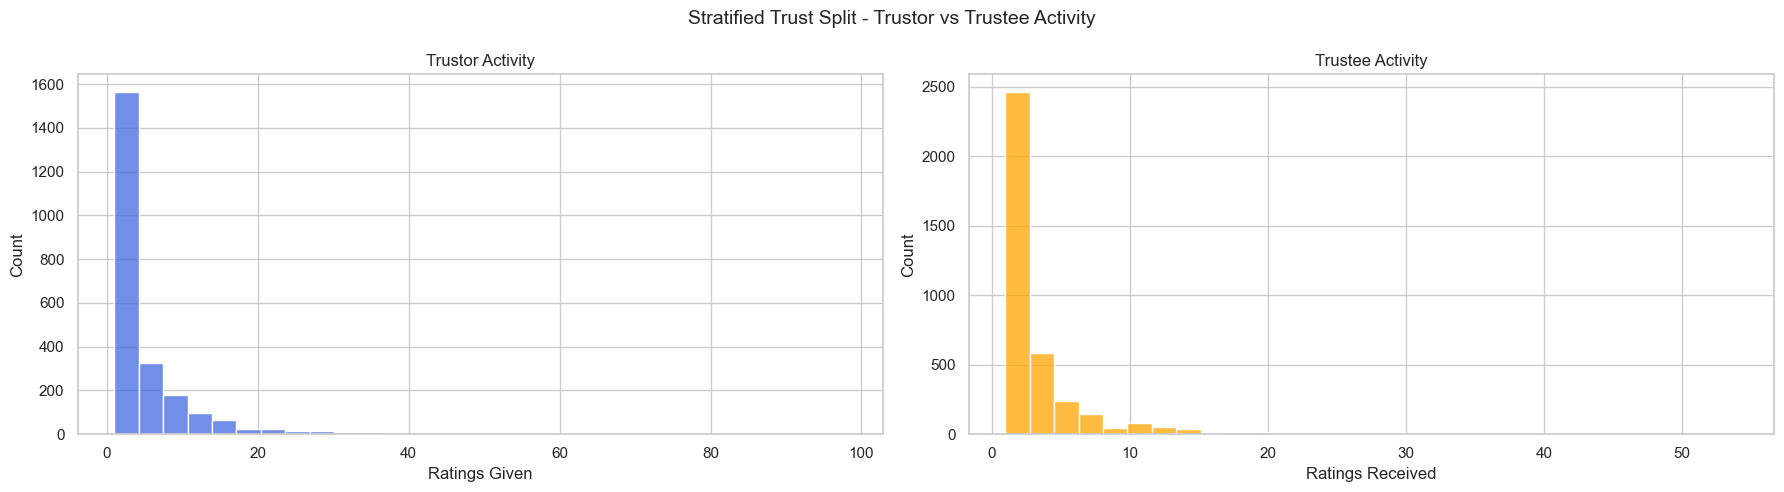

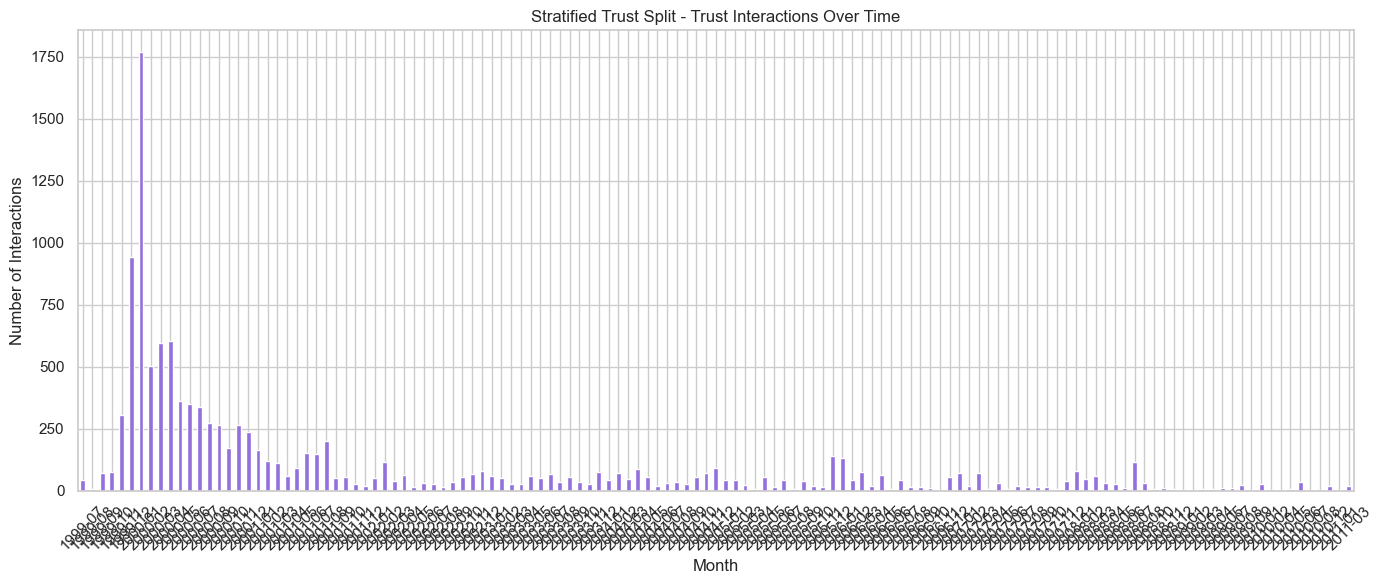


📊 Visualizing: High Quality Non-Zero Split


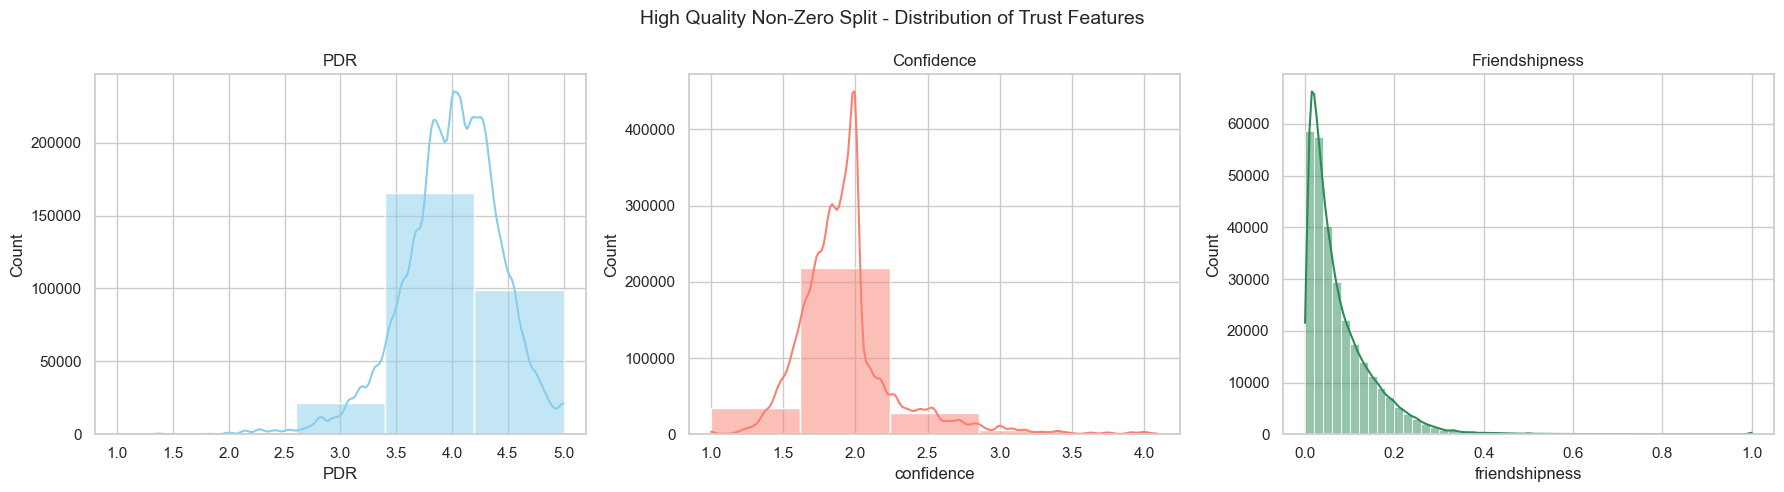

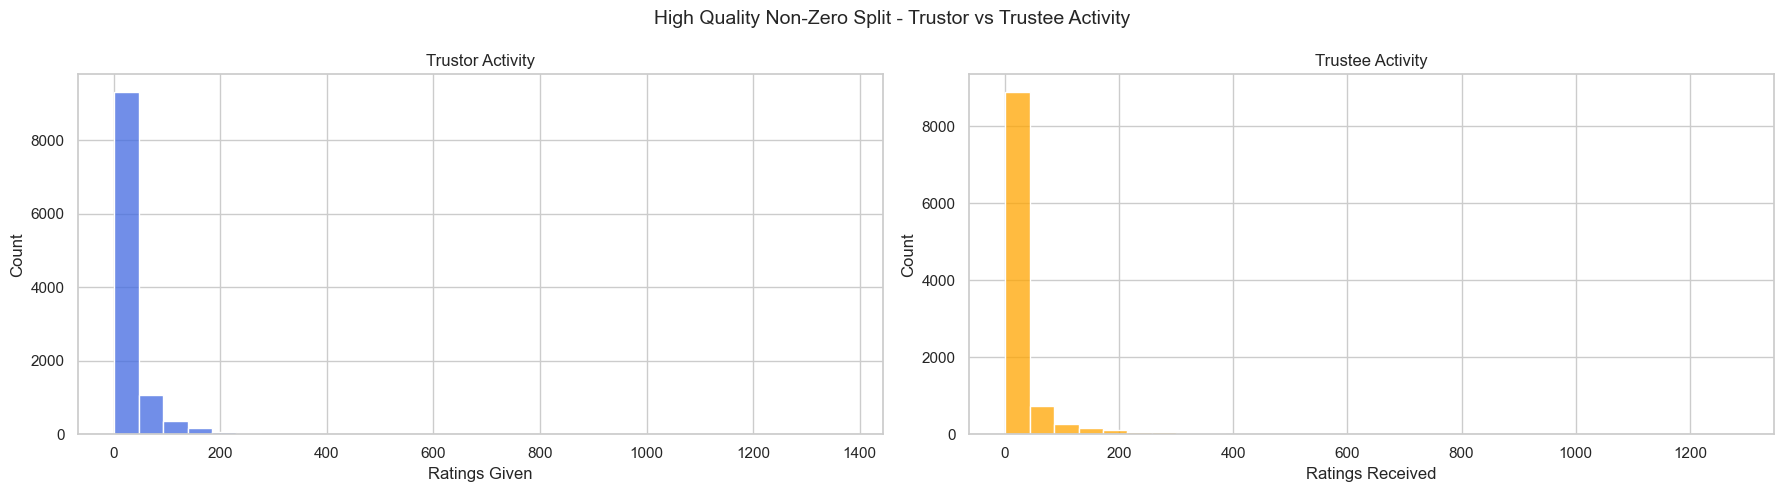

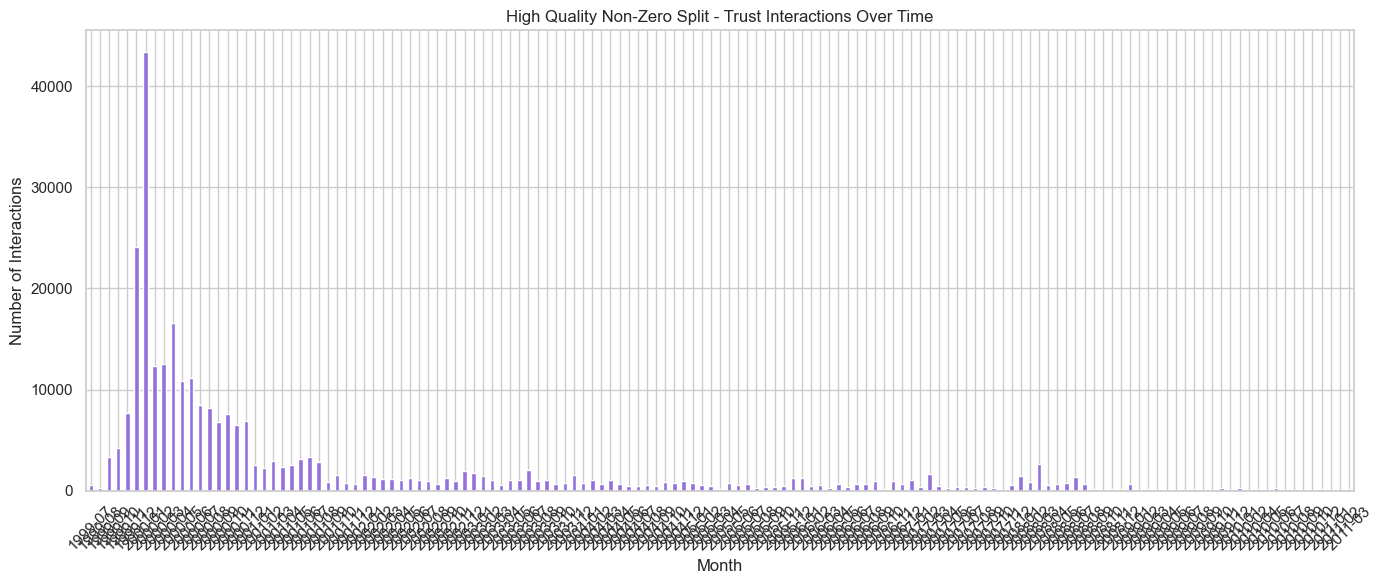

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Set up plotting style ===
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# === File paths (relative, portable) ===
files = {
    "Stratified Trust Split": Path("Stratified_Trust_Split.csv"),
    "High Quality Non-Zero Split": Path("High_Quality_Trust_Split_NonZero.csv")
}

# === Visualization Loop ===
for label, path in files.items():
    print(f"\n📊 Visualizing: {label}")
    
    if path.exists():
        df = pd.read_csv(path)
    else:
        raise FileNotFoundError(f"Required file '{path}' not found. Please ensure it's generated or uploaded.")
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # -------- Plot 1: Distributions --------
    fig1, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig1.suptitle(f"{label} - Distribution of Trust Features", fontsize=14)

    sns.histplot(df['PDR'], bins=5, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title("PDR")

    sns.histplot(df['confidence'], bins=5, kde=True, ax=axes[1], color='salmon')
    axes[1].set_title("Confidence")

    sns.histplot(df['friendshipness'], bins=50, kde=True, ax=axes[2], color='seagreen')
    axes[2].set_title("Friendshipness")

    plt.tight_layout()
    plt.show()

    # -------- Plot 2: Trustor vs Trustee Activity --------
    trustor_counts = df['trustor'].value_counts()
    trustee_counts = df['trustee'].value_counts()

    fig2, axes = plt.subplots(1, 2, figsize=(18, 5))
    fig2.suptitle(f"{label} - Trustor vs Trustee Activity", fontsize=14)

    sns.histplot(trustor_counts, bins=30, ax=axes[0], color='royalblue')
    axes[0].set_title("Trustor Activity")
    axes[0].set_xlabel("Ratings Given")

    sns.histplot(trustee_counts, bins=30, ax=axes[1], color='orange')
    axes[1].set_title("Trustee Activity")
    axes[1].set_xlabel("Ratings Received")

    plt.tight_layout()
    plt.show()

    # -------- Plot 3: Time Trend --------
    df['month'] = df['timestamp'].dt.to_period('M')
    monthly_counts = df.groupby('month').size()

    fig3, ax3 = plt.subplots(figsize=(14, 6))
    monthly_counts.plot(kind='bar', ax=ax3, color='mediumpurple')
    ax3.set_title(f"{label} - Trust Interactions Over Time")
    ax3.set_xlabel("Month")
    ax3.set_ylabel("Number of Interactions")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Calculate Mean Trust Given and Received

This block calculates two key relational trust metrics:
1. `mean_trust_given` → the average `total` trust score each **trustor gives** to others
2. `mean_trust_received` → the average `total` trust score each **trustee receives** from others

These metrics help contextualize each user's behavior in the trust network — identifying how generous or trusted they are, on average — and are added back into the main dataset for further comparative analysis.

---

#### 🧠 Why This Matters

The individual `total` score for a trustor–trustee pair captures a **specific interaction**, but aggregated averages across users reveal **system-level behavior**:

- **High `mean_trust_given`** → overly trusting users (possible inflation or manipulation)
- **Low `mean_trust_given`** → conservative or skeptical trustors
- **High `mean_trust_received`** → trusted or popular users (or ballot-stuffed)
- **Low `mean_trust_received`** → potentially untrustworthy users

These features are later used in:
- **Anomaly detection** (to find outliers in trust behavior)
- **Ballot stuffing analysis** (e.g., few ratings received but very high averages)
- **Visualization and ranking of trust profiles**

---

#### ⚙️ Implementation Steps

1. **Mean Trust Given (Trustor-Level)**:
   ```python
   trust_given_scores = df.groupby('trustor')['total'].mean().reset_index()
   trust_given_scores.columns = ['trustor', 'mean_trust_given']
   df = df.merge(trust_given_scores, on='trustor', how='left')


In [14]:
# Work on a copy of the filtered dataset
df = high_quality_split.copy()

# === Step 1: Mean total trust given by each trustor ===
trust_given_scores = df.groupby('trustor')['total'].mean().reset_index()
trust_given_scores.columns = ['trustor', 'mean_trust_given']
df = df.merge(trust_given_scores, on='trustor', how='left')

print("✅ 'mean_trust_given' column added.")
print(df[['trustor', 'total', 'mean_trust_given']].head())

# === Step 2: Mean total trust received by each trustee ===
trust_received_scores = df.groupby('trustee')['total'].mean().reset_index()
trust_received_scores.columns = ['trustee', 'mean_trust_received']
df = df.merge(trust_received_scores, on='trustee', how='left')

print("✅ 'mean_trust_received' column added.")
print(df[['trustee', 'total', 'mean_trust_received']].head())

# Update main reference
high_quality_split = df


✅ 'mean_trust_given' column added.
   trustor     total  mean_trust_given
0        2  1.160683          1.162498
1        2  1.164312          1.162498
2        5  1.351416          1.364538
3        5  1.357674          1.364538
4        5  1.345933          1.364538
✅ 'mean_trust_received' column added.
   trustee     total  mean_trust_received
0    14613  1.160683             1.323796
1    20190  1.164312             1.298541
2     1927  1.351416             1.296727
3     2117  1.357674             1.327856
4    11261  1.345933             1.315913


### Normalize Mean Trust Scores
This block verifies the presence of mean trust columns and normalizes:
- `mean_trust_given` → `N_mean_trust_given`
- `mean_trust_received` → `N_mean_trust_received`

These values scale between 0 and 1, enabling consistent comparison across different users.


In [15]:
# Ensure required columns exist
required_cols = {'mean_trust_given', 'mean_trust_received'}
if not required_cols.issubset(high_quality_split.columns):
    raise ValueError("❌ Missing columns. Run trust mean score calculations first.")

# Normalize trust given
max_given = high_quality_split['mean_trust_given'].max()
high_quality_split['N_mean_trust_given'] = high_quality_split['mean_trust_given'] / max_given

# Normalize trust received
max_received = high_quality_split['mean_trust_received'].max()
high_quality_split['N_mean_trust_received'] = high_quality_split['mean_trust_received'] / max_received

# Preview
print("✅ Normalized columns added: 'N_mean_trust_given', 'N_mean_trust_received'")
print(high_quality_split[['mean_trust_given', 'N_mean_trust_given', 'mean_trust_received', 'N_mean_trust_received']].head())


✅ Normalized columns added: 'N_mean_trust_given', 'N_mean_trust_received'
   mean_trust_given  N_mean_trust_given  mean_trust_received  \
0          1.162498            0.476589             1.323796   
1          1.162498            0.476589             1.298541   
2          1.364538            0.559420             1.296727   
3          1.364538            0.559420             1.327856   
4          1.364538            0.559420             1.315913   

   N_mean_trust_received  
0               0.532932  
1               0.522764  
2               0.522034  
3               0.534566  
4               0.529758  


### Detect Ballot Stuffing: High Score from Low Ratings

This block flags **trustees who receive unusually high average trust scores despite having very few total ratings**. This pattern may indicate **ballot stuffing** — a manipulation strategy where a small number of trustors inflate a trustee’s reputation by assigning them consistently high trust values.

---

#### 🧠 What Is Ballot Stuffing?

Ballot stuffing occurs when a user receives **artificially elevated ratings** from a small group of collaborators or bots, causing their average trust score to be disproportionately high.

For example:
- A trustee receives a `total` trust score of 2.8 on average
- But they only received 4 ratings
- This mismatch between **quantity** and **quality** raises suspicion

---

#### 📊 Methodology

1. **Trustee-Level Aggregation**:
   The following two metrics are calculated for each trustee:
   ```python
   trustee_summary = df.groupby('trustee')['total'].agg(['mean', 'count']).reset_index()
   trustee_summary.columns = ['trustee', 'avg_trust_score', 'rating_count']


C:\Users\banga\AppData\Local\Temp\ipykernel_28400\1461768247.py:36: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  plt.tight_layout()
C:\Users\banga\AppData\Local\Temp\ipykernel_28400\1461768247.py:36: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  plt.tight_layout()
C:\Users\banga\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\banga\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


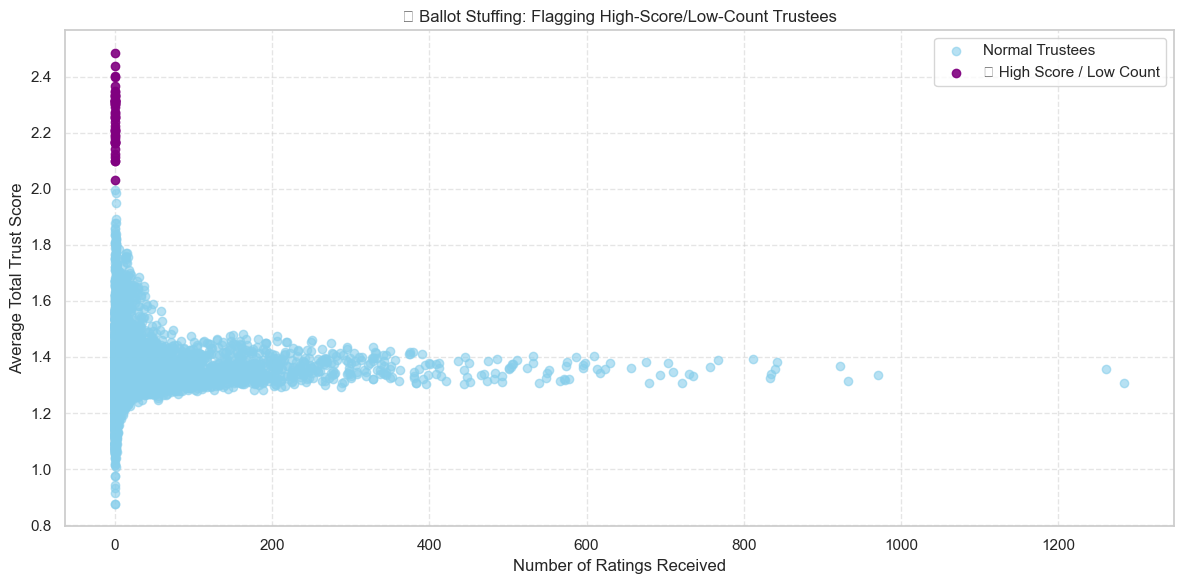

In [16]:
import matplotlib.pyplot as plt

# === Step 1: Compute trustee-level trust statistics ===
trustee_summary = high_quality_split.groupby('trustee')['total'].agg(['mean', 'count']).reset_index()
trustee_summary.columns = ['trustee', 'avg_trust_score', 'rating_count']

# === Step 2: Flag manual outliers (ballot stuffing suspects) ===
trustee_summary['manual_outlier'] = (
    (trustee_summary['avg_trust_score'] >= 2.0) &
    (trustee_summary['rating_count'] <= 10)
)

# === Step 3: Scatter plot of rating count vs average trust ===
plt.figure(figsize=(12, 6))

# Normal trustees
plt.scatter(
    trustee_summary[~trustee_summary['manual_outlier']]['rating_count'],
    trustee_summary[~trustee_summary['manual_outlier']]['avg_trust_score'],
    color='skyblue', alpha=0.6, label='Normal Trustees'
)

# Suspected ballot stuffers
plt.scatter(
    trustee_summary[trustee_summary['manual_outlier']]['rating_count'],
    trustee_summary[trustee_summary['manual_outlier']]['avg_trust_score'],
    color='purple', alpha=0.9, label='🚨 High Score / Low Count'
)

# === Step 4: Formatting and legend ===
plt.title("📌 Ballot Stuffing: Flagging High-Score/Low-Count Trustees")
plt.xlabel("Number of Ratings Received")
plt.ylabel("Average Total Trust Score")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


### Trustees: Percentage of Low Ratings (Bad Mouthing)

This analysis identifies trustees who consistently receive **low trust scores**, potentially as a result of **bad mouthing attacks**, controversial behavior, or genuine untrustworthiness.

A **bad mouthing attack** occurs when a group of trustors deliberately assigns low scores to a target user to damage their reputation — often seen in competitive or adversarial systems.

---

#### 🧠 Motivation

- High **frequency** of low scores from multiple users can be a strong indicator of reputation sabotage.
- Not every low score is suspicious, but a **high percentage** of them, especially if coordinated, merits deeper analysis.
- This also helps detect **polarizing** trustees: users who may receive a lot of attention (e.g., influencers, vendors) but provoke mixed or negative sentiment.

---

#### ⚙️ Implementation Logic

1. **Define a Low Score Threshold**:
   The threshold is configurable. Here, it is set to `1.25`:
   ```python
   LOW_SCORE_THRESHOLD


C:\Users\banga\AppData\Local\Temp\ipykernel_28400\2781393387.py:24: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\banga\AppData\Local\Temp\ipykernel_28400\2781393387.py:24: UserWarning: Glyph 128681 (\N{TRIANGULAR FLAG ON POST}) missing from current font.
  plt.tight_layout()
C:\Users\banga\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128721 (\N{OCTAGONAL SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\banga\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128681 (\N{TRIANGULAR FLAG ON POST}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


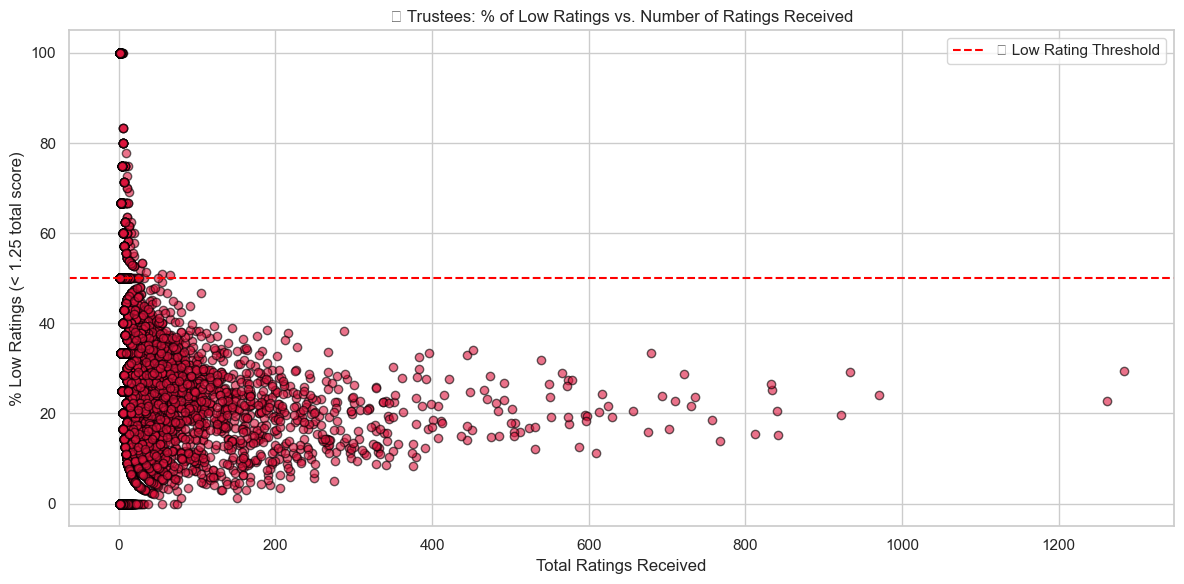

In [17]:
# Calculate low score percentage
trustee_low_stats = high_quality_split.groupby('trustee').agg(
    total_ratings=('total', 'count'),
    low_score_count=('total', lambda x: (x < 1.25).sum())
).reset_index()

trustee_low_stats['low_score_percent'] = (
    trustee_low_stats['low_score_count'] / trustee_low_stats['total_ratings']
) * 100

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(
    trustee_low_stats['total_ratings'], 
    trustee_low_stats['low_score_percent'],
    alpha=0.6, color='crimson', edgecolor='black'
)
plt.axhline(50, linestyle='--', color='red', label="🚩 Low Rating Threshold")
plt.title("🛑 Trustees: % of Low Ratings vs. Number of Ratings Received")
plt.xlabel("Total Ratings Received")
plt.ylabel("% Low Ratings (< 1.25 total score)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Detect Anomalous Trustors Using Isolation Forest

This section applies the **Isolation Forest** algorithm — an unsupervised anomaly detection method — to identify **trustors** whose overall trust behavior deviates significantly from the population.

It leverages statistical and graph-based trust features to detect suspicious users who may be exhibiting:
- Unusual generosity or harshness
- Highly volatile trust patterns
- Automated or coordinated rating behavior

---

#### 🤖 Why Isolation Forest?

Isolation Forest works by randomly selecting features and splitting values to **isolate data points**. Anomalies are easier to isolate and thus require fewer random splits. It’s ideal for detecting:
- Global outliers (very different users)
- Local outliers (trustors in dense clusters with distinct behavior)

Key benefits:
- Scales well to large datasets
- Works without labeled anomalies
- Performs well on skewed trust distributions

---

#### 📊 Features Used

Four trustor-level features are computed from `df`:
```python
agg_df = df.groupby('trustor').agg({
    'total': ['mean', 'std'],
    'interaction_count': 'sum',
    'friendshipness': 'mean'
}).reset_index()


C:\Users\banga\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\banga\AppData\Local\Temp\ipykernel_28400\22633353.py:47: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  plt.tight_layout()
C:\Users\banga\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


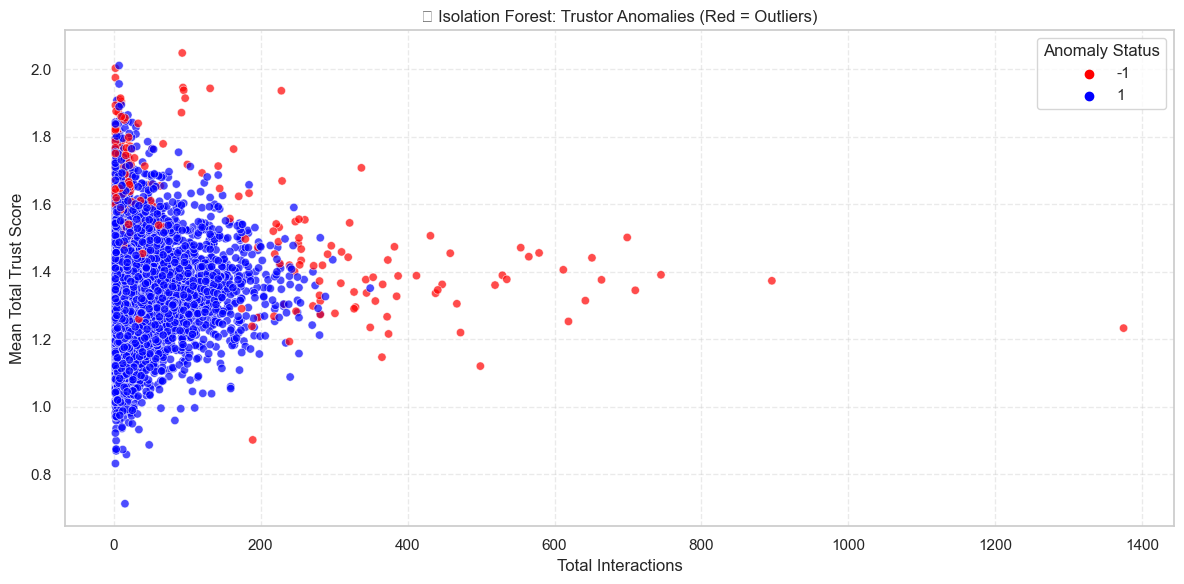

🔴 Top 10 Anomalous Trustors:
     trustor  mean_total  std_total  interaction_count  mean_friendshipness  \
22        44    1.540311   0.195074                 23             0.366850   
32        61    1.219752   0.053514                472             0.077859   
35        66    1.687940   0.189534                  3             0.238522   
81       153    1.788251   0.193506                  7             0.437918   
165      321    1.764476   0.166732                 52             0.259825   
187      372    1.639244   0.000000                  2             0.250000   
196      389    1.458920   0.039791                310             0.056039   
227      469    1.654803   0.140985                  4             0.312500   
236      485    1.726494   0.220690                 10             0.337691   
244      505    1.419428   0.081259                284             0.159866   

     anomaly  
22        -1  
32        -1  
35        -1  
81        -1  
165       -1  
187       -

In [18]:
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === Step 1: Load dataset ===
file_path = Path("High_Quality_Trust_Split_NonZero.csv")
if file_path.exists():
    df = pd.read_csv(file_path)
else:
    raise FileNotFoundError("Required file 'High_Quality_Trust_Split_NonZero.csv' not found. Please regenerate or provide it.")

df['timestamp'] = pd.to_datetime(df['timestamp'])

# === Step 2: Aggregate trustor statistics ===
agg_df = df.groupby('trustor').agg({
    'total': ['mean', 'std'],
    'interaction_count': 'sum',
    'friendshipness': 'mean'
}).reset_index()

# Flatten column names from MultiIndex
agg_df.columns = ['trustor', 'mean_total', 'std_total', 'interaction_count', 'mean_friendshipness']
agg_df.dropna(inplace=True)

# === Step 3: Run Isolation Forest ===
features = agg_df[['mean_total', 'std_total', 'interaction_count', 'mean_friendshipness']]
model = IsolationForest(contamination=0.03, random_state=42)
agg_df['anomaly'] = model.fit_predict(features)

# === Step 4: Visualize anomalies ===
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=agg_df,
    x='interaction_count',
    y='mean_total',
    hue='anomaly',
    palette={1: 'blue', -1: 'red'},
    alpha=0.7
)
plt.title("🔍 Isolation Forest: Trustor Anomalies (Red = Outliers)")
plt.xlabel("Total Interactions")
plt.ylabel("Mean Total Trust Score")
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend(title="Anomaly Status")
plt.tight_layout()
plt.show()

# === Step 5: Display top 10 anomalous trustors ===
anomalous = agg_df[agg_df['anomaly'] == -1]
print("🔴 Top 10 Anomalous Trustors:")
print(anomalous.head(10))


### Trust Score Over Time: Top 60 Anomalous Trustors

This visualization plots the **evolution of trust scores over time** for the top 60 anomalous trustors as identified by the Isolation Forest algorithm. It is designed to reveal **temporal patterns of anomalous behavior** that may not be evident in aggregate statistics alone.

---

#### 🎯 Purpose

While anomaly detection models highlight who is unusual, this plot answers **how** they behave over time:
- Do their trust scores swing back and forth (On-Off behavior)?
- Do they consistently inflate or deflate trust?
- Are there suspicious bursts of high trust within narrow windows?

This enables **temporal anomaly profiling**, vital for detecting subtle or evolving attack patterns.

---

#### 📊 Methodology

1. **Start from Isolation Forest output**:
   Use the same trustor-level `agg_df` with anomaly labels.

2. **Select Top 60 Anomalous Trustors**:
   Anomalies are sorted by `mean_total` in descending order — prioritizing those who are both anomalous and extremely generous in trust. This ordering helps catch users most likely to be performing **reputation inflation**.

3. **Color Tiers Based on Rank**:
   Trustors are color-coded in tiers:
   - 🔴 Top 10 → `red`
   - 🔶 11–20 → `lightcoral`
   - 🟠 21–30 → `orange`
   - 🟡 31–40 → `gold`
   - 🟢 41–50 → `yellowgreen`
   - 🔵 51–60 → `lightblue`

   This ranking-based coloring conveys **severity within anomaly space**, offering visual prioritization


C:\Users\banga\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\banga\AppData\Local\Temp\ipykernel_28400\1411411684.py:69: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  plt.tight_layout()
C:\Users\banga\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128680 (\N{POLICE CARS REVOLVING LIGHT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


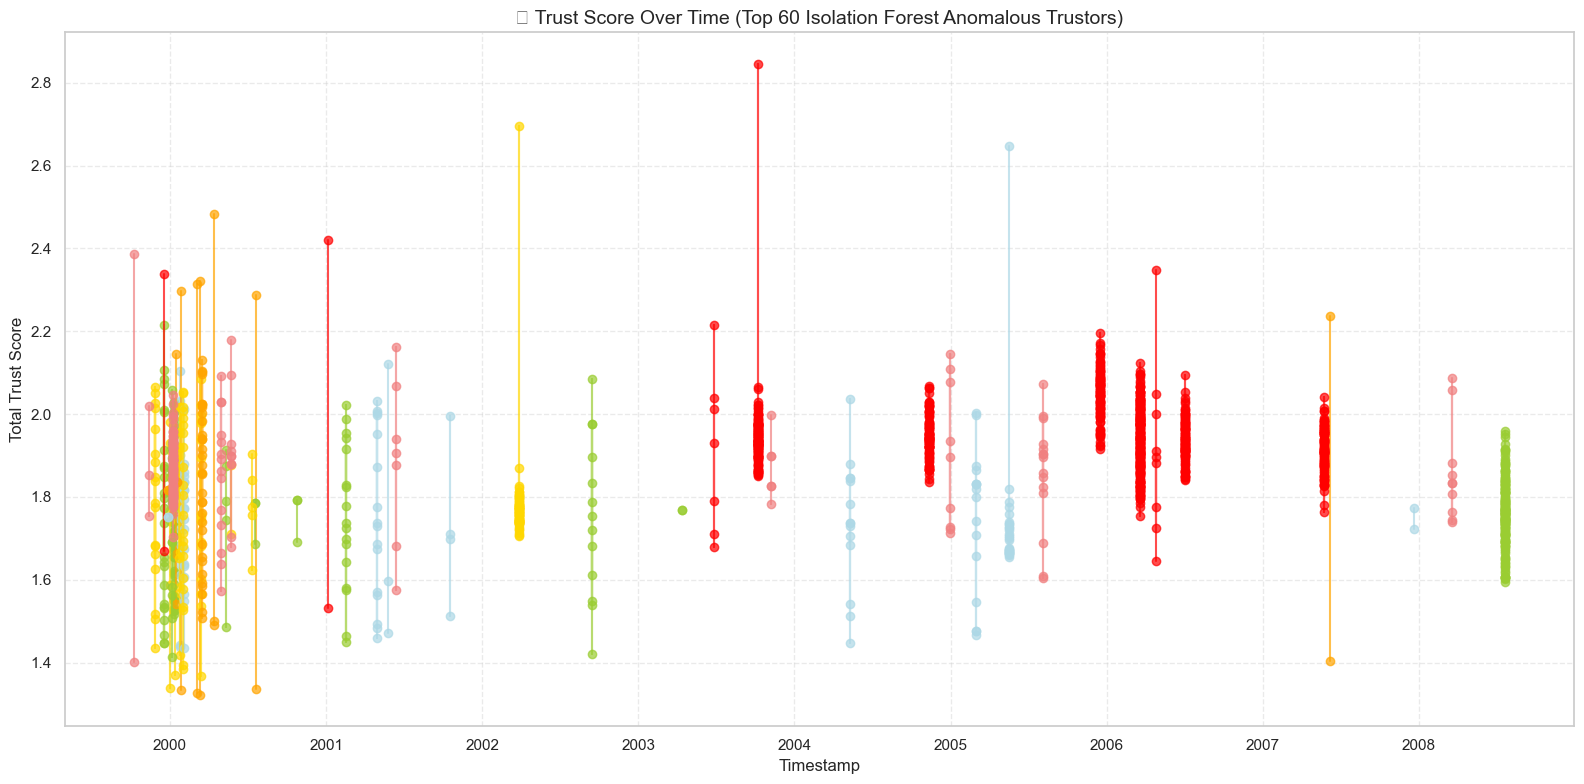

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from pathlib import Path

# === Step 1: Load the dataset ===
file_path = Path("High_Quality_Trust_Split_NonZero.csv")
if file_path.exists():
    df = pd.read_csv(file_path)
else:
    raise FileNotFoundError("Required file 'High_Quality_Trust_Split_NonZero.csv' not found. Please regenerate or provide it.")

df['timestamp'] = pd.to_datetime(df['timestamp'])

# === Step 2: Aggregate trustor-level metrics ===
agg_df = df.groupby('trustor').agg({
    'total': ['mean', 'std'],
    'interaction_count': 'sum',
    'friendshipness': 'mean'
}).reset_index()
agg_df.columns = ['trustor', 'mean_total', 'std_total', 'interaction_count', 'mean_friendshipness']

# === Step 3: Run Isolation Forest ===
features = agg_df[['mean_total', 'std_total', 'interaction_count', 'mean_friendshipness']]

# Drop rows with NaNs in any of the selected features
features = features.dropna()
agg_df = agg_df.loc[features.index]  # keep only rows with valid features

# Fit model
model = IsolationForest(contamination=0.03, random_state=42)
agg_df['anomaly'] = model.fit_predict(features)

# === Step 4: Extract top 60 anomalies ===
top_anomalies = agg_df[agg_df['anomaly'] == -1].copy()
top_anomalies = top_anomalies.sort_values(by='mean_total', ascending=False).head(60).reset_index(drop=True)
top_anomaly_ids = top_anomalies['trustor'].tolist()

# Assign color tiers based on rank
def assign_color(idx):
    if idx < 10: return 'red'
    elif idx < 20: return 'lightcoral'
    elif idx < 30: return 'orange'
    elif idx < 40: return 'gold'
    elif idx < 50: return 'yellowgreen'
    else: return 'lightblue'

top_anomalies['color'] = top_anomalies.index.map(assign_color)

# === Step 5: Merge color info into filtered trustor timeline ===
df_anomalous = df[df['trustor'].isin(top_anomaly_ids)].copy()
df_anomalous = df_anomalous.merge(top_anomalies[['trustor', 'color']], on='trustor', how='left')

# === Step 6: Plot score evolution ===
plt.figure(figsize=(16, 8))
for trustor_id, group in df_anomalous.groupby('trustor'):
    group = group.sort_values('timestamp')
    plt.plot(
        group['timestamp'], group['total'],
        marker='o', linestyle='-', alpha=0.7,
        color=group['color'].iloc[0],
        label=f'Trustor {trustor_id}'
    )

plt.title("🚨 Trust Score Over Time (Top 60 Isolation Forest Anomalous Trustors)", fontsize=14)
plt.xlabel("Timestamp")
plt.ylabel("Total Trust Score")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


C:\Users\banga\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\banga\AppData\Local\Temp\ipykernel_28400\455843661.py:52: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  plt.tight_layout()
C:\Users\banga\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


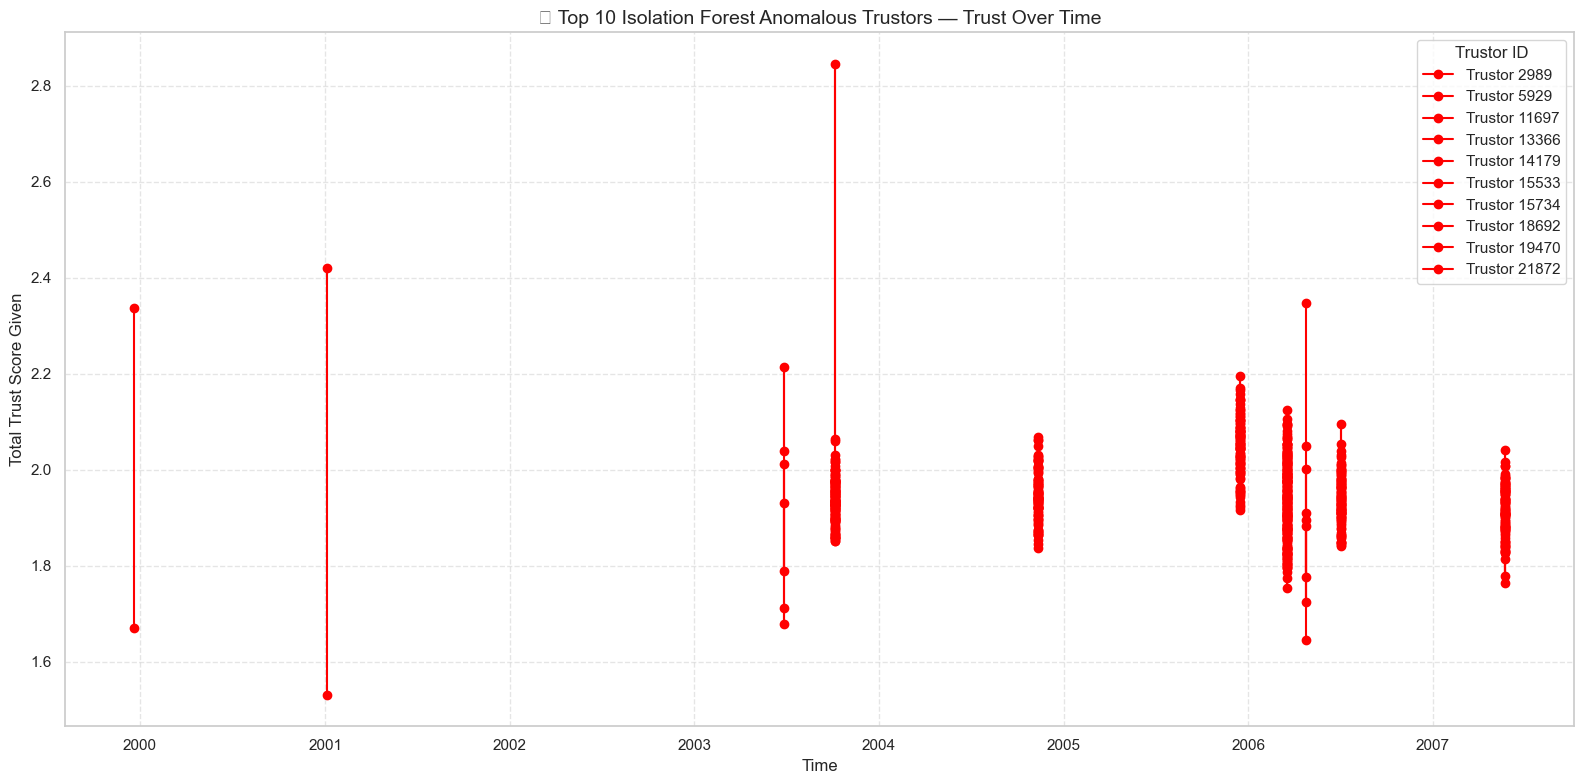

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from pathlib import Path

# === Step 1: Load your dataset ===
file_path = Path("High_Quality_Trust_Split_NonZero.csv")
if file_path.exists():
    df = pd.read_csv(file_path)
else:
    raise FileNotFoundError("Required file 'High_Quality_Trust_Split_NonZero.csv' not found. Please regenerate or provide it.")

df['timestamp'] = pd.to_datetime(df['timestamp'])

# === Step 2: Aggregate trustor-level features ===
agg_df = df.groupby('trustor').agg({
    'total': ['mean', 'std'],
    'interaction_count': 'sum',
    'friendshipness': 'mean'
}).reset_index()
agg_df.columns = ['trustor', 'mean_total', 'std_total', 'interaction_count', 'mean_friendshipness']

# === Step 3: Prepare features & clean ===
features = agg_df[['mean_total', 'std_total', 'interaction_count', 'mean_friendshipness']].dropna()
agg_df = agg_df.loc[features.index]

# === Step 4: Run Isolation Forest ===
model = IsolationForest(contamination=0.03, random_state=42)
agg_df['anomaly'] = model.fit_predict(features)

# === Step 5: Get top 10 anomalous trustors (ranked by mean total score) ===
top_anomalies = agg_df[agg_df['anomaly'] == -1].copy()
top_10_anomalies = top_anomalies.sort_values(by='mean_total', ascending=False).head(10)
top_10_ids = top_10_anomalies['trustor'].tolist()

# === Step 6: Filter main dataset for those trustors ===
df_top_10 = df[df['trustor'].isin(top_10_ids)].copy()
df_top_10['timestamp'] = pd.to_datetime(df_top_10['timestamp'])

# === Step 7: Plot each trustor in red ===
plt.figure(figsize=(16, 8))
for trustor_id, group in df_top_10.groupby('trustor'):
    group = group.sort_values('timestamp')
    plt.plot(group['timestamp'], group['total'], marker='o', linestyle='-', label=f'Trustor {trustor_id}', color='red')

# === Formatting ===
plt.title("🔴 Top 10 Isolation Forest Anomalous Trustors — Trust Over Time", fontsize=14)
plt.xlabel("Time")
plt.ylabel("Total Trust Score Given")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Trustor ID")
plt.tight_layout()
plt.show()


### Simulate On-Off Attack: High-Volume Trustors
Injects On-Off trust behavior into the timelines of trustors with ≥ 200 interactions. Alternates trust scores (e.g., 0.2, 2.5...) to simulate suspicious switching behavior and evade detection over ~10% of their rating history.


In [21]:
import pandas as pd
from datetime import timedelta
from pathlib import Path

# === Load original high-quality dataset ===
file_path = Path("High_Quality_Trust_Split_NonZero.csv")
if file_path.exists():
    df = pd.read_csv(file_path)
else:
    raise FileNotFoundError("Required file 'High_Quality_Trust_Split_NonZero.csv' not found. Please regenerate or provide it.")

df['timestamp'] = pd.to_datetime(df['timestamp'])

# === Step 1: Identify trustors with ≥ 200 interactions ===
trustor_counts = df['trustor'].value_counts()
high_volume_trustors = trustor_counts[trustor_counts >= 200].index.tolist()

# === Step 2: Select top 5 trustors for injection (deterministic or random sample) ===
target_trustors = high_volume_trustors[:5]
print("🎯 Selected trustors for On-Off attack injection:", target_trustors)

# === Step 3: Inject On-Off attack into ~10% of each trustor's records ===
df_onoff_injected = df.copy()

for trustor in target_trustors:
    t_rows = df_onoff_injected[df_onoff_injected['trustor'] == trustor].sort_values(by='timestamp').copy()
    count_to_modify = max(12, int(len(t_rows) * 0.1))  # at least 12 points or 10%
    
    # Create alternating pattern: 0.2, 2.5, 0.2, 2.5, ...
    pattern = [0.2 if i % 2 == 0 else 2.5 for i in range(count_to_modify)]
    
    # Inject pattern into earliest N timestamps
    df_onoff_injected.loc[t_rows.index[:count_to_modify], 'total'] = pattern

print("✅ On-Off attack injected into top high-volume trustors (~10% of interactions modified).")

# === Step 4: Save the attacked dataset ===
output_path = Path("Injected_OnOff_HighVolume.csv")
df_onoff_injected.to_csv(output_path, index=False)
print(f"📁 Injected dataset saved to: {output_path}")


🎯 Selected trustors for On-Off attack injection: [14547, 12804, 18620, 3426, 19837]
✅ On-Off attack injected into top high-volume trustors (~10% of interactions modified).
📁 Injected dataset saved to: Injected_OnOff_HighVolume.csv


### Simulate On-Off Attack: High-Volume Trustors

This block programmatically injects a **simulated On-Off trust manipulation attack** into the dataset by modifying the trust score timelines of trustors who have **200 or more recorded interactions**. The attack alternates between very low and very high trust scores (e.g., 0.2 and 2.5) to mimic **evasive, oscillating behavior** commonly used to avoid detection in anomaly detection systems.

---

#### 🎯 What Is an On-Off Attack?

An On-Off attack is a **temporal trust manipulation technique** where:
- A user behaves normally or positively most of the time
- Occasionally injects **malicious behavior** (e.g., low trust scores or fake scores)
- Alternates ("flips") between good and bad behavior to confuse unsupervised anomaly detection algorithms

This is analogous to spam accounts or bots that mimic human behavior intermittently to avoid being flagged.

---

#### ⚙️ Implementation Details

1. **Filter for High-Volume Trustors**:
   Trustors with ≥ 200 interactions are selected:
   ```python
   trustor_counts = df['trustor'].value_counts()
   high_volume_trustors = trustor_counts[trustor_counts >= 200].index.tolist()


C:\Users\banga\AppData\Local\Temp\ipykernel_28400\3353109426.py:34: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  plt.tight_layout()
C:\Users\banga\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128257 (\N{CLOCKWISE RIGHTWARDS AND LEFTWARDS OPEN CIRCLE ARROWS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


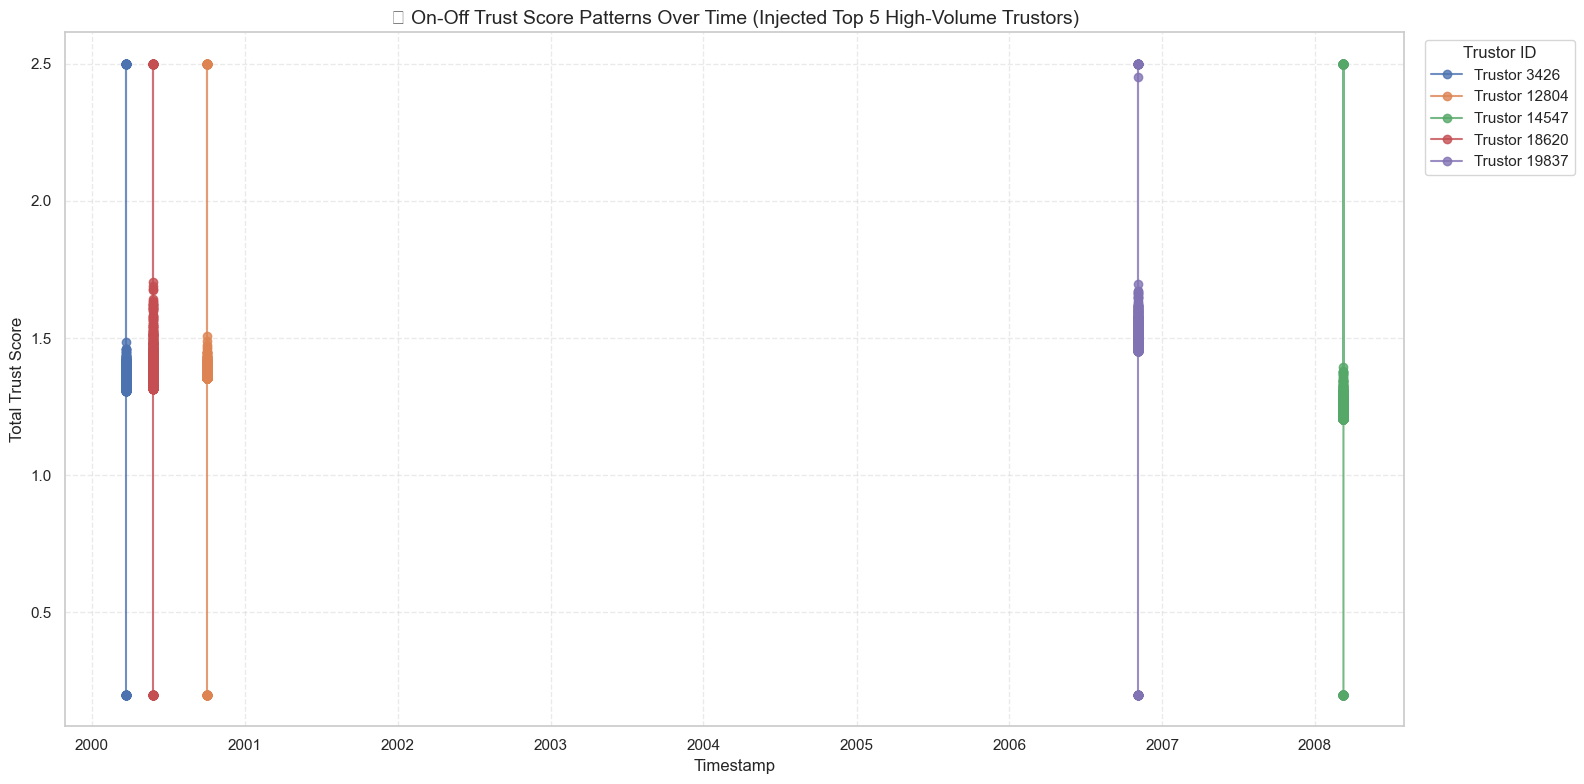

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# === Load injected dataset ===
file_path = Path("Injected_OnOff_HighVolume.csv")
if file_path.exists():
    df_attack = pd.read_csv(file_path)
else:
    raise FileNotFoundError("Required file 'Injected_OnOff_HighVolume.csv' not found. Please regenerate or provide it.")

df_attack['timestamp'] = pd.to_datetime(df_attack['timestamp'])

# === Step 1: Re-identify the top 5 trustors used for attack ===
trustor_counts = df_attack['trustor'].value_counts()
target_trustors = trustor_counts[trustor_counts >= 200].index[:5].tolist()  # same logic as injection

# === Step 2: Filter only attacked users ===
df_viz = df_attack[df_attack['trustor'].isin(target_trustors)].copy()

# === Step 3: Plot each trustor's timeline ===
plt.figure(figsize=(16, 8))
for trustor_id, group in df_viz.groupby('trustor'):
    sorted_group = group.sort_values(by='timestamp')
    plt.plot(sorted_group['timestamp'], sorted_group['total'],
             marker='o', linestyle='-', label=f'Trustor {trustor_id}', alpha=0.8)

# === Formatting ===
plt.title("🔁 On-Off Trust Score Patterns Over Time (Injected Top 5 High-Volume Trustors)", fontsize=14)
plt.xlabel("Timestamp")
plt.ylabel("Total Trust Score")
plt.legend(title="Trustor ID", bbox_to_anchor=(1.01, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


### Heatmap: Detect Ballot Stuffing Patterns

This block generates a heatmap that visualizes the **average `total` trust scores** assigned from the top 100 most active trustors to the top 30 most frequently rated trustees. The goal is to uncover **localized zones of inflated trust**, which may indicate **ballot stuffing**, collusion, or strategic trust inflation.

---

#### 🎯 What Is Ballot Stuffing?

Ballot stuffing in trust systems occurs when a group of users (trustors) collaborate or are manipulated to assign **consistently high trust scores** to a specific trustee or group of trustees. This may occur in:
- Online reputation systems
- Marketplace ratings
- Decentralized networks

Such inflation boosts the target’s perceived trustworthiness and may mislead models or users into treating them as reputable entities.

---

#### ⚙️ Implementation Breakdown

1. **Subset the Dataset**:
   The most active users are selected to ensure the heatmap is dense and focused:
   - Top 100 **trustors** (most ratings given)
   - Top 30 **trustees** (most ratings received)
   ```python
   top_trustors = df['trustor'].value_counts().head(100).index.tolist()
   top_trustees = df['trustee'].value_counts().head(30).index.tolist()


C:\Users\banga\AppData\Local\Temp\ipykernel_28400\1039617287.py:44: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  plt.tight_layout()
C:\Users\banga\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128293 (\N{FIRE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


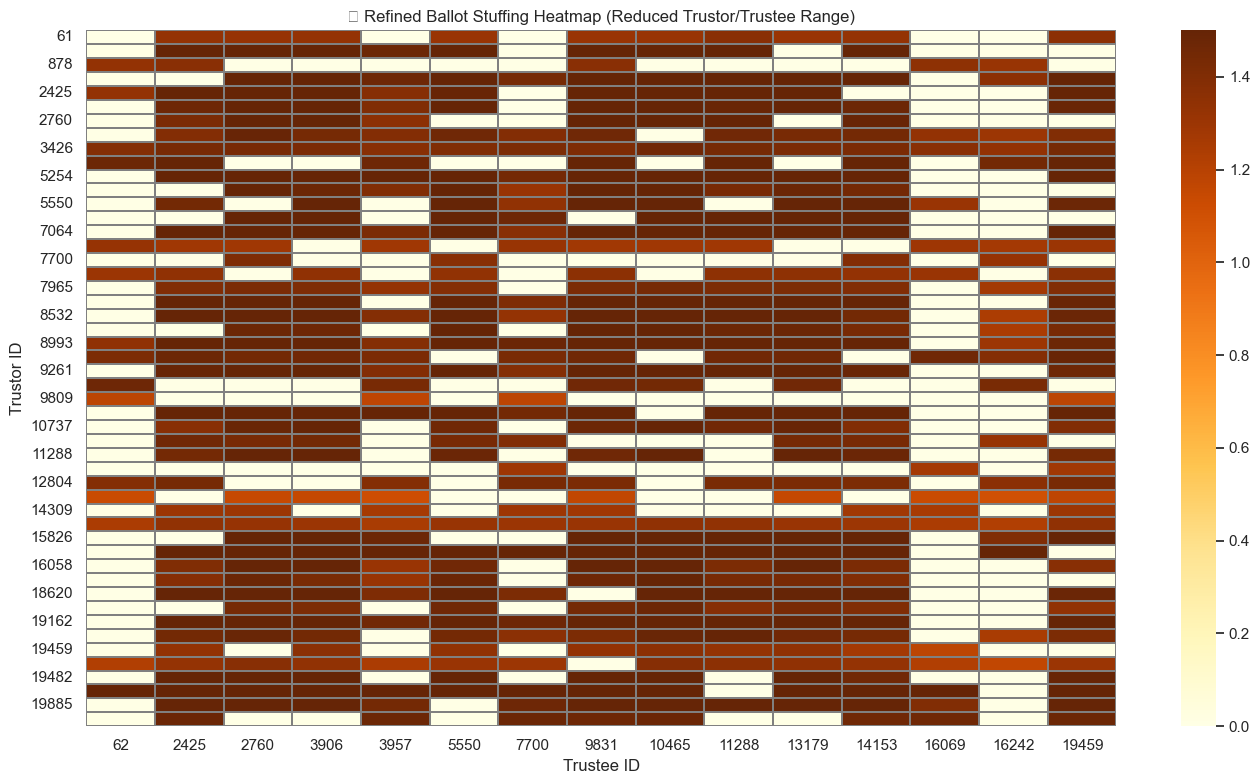

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Load the dataset
file_path = Path("High_Quality_Trust_Split_NonZero.csv")
if file_path.exists():
    df = pd.read_csv(file_path)
else:
    raise FileNotFoundError("Required file 'High_Quality_Trust_Split_NonZero.csv' not found. Please regenerate or provide it.")

# Step 1: Filter top trustees (fewer than before)
top_trustees = df['trustee'].value_counts().head(15).index.tolist()

# Step 2: Filter top trustors (fewer than before)
top_trustors = df['trustor'].value_counts().head(50).index.tolist()

# Step 3: Subset the DataFrame
df_subset = df[df['trustor'].isin(top_trustors) & df['trustee'].isin(top_trustees)]

# Step 4: Create pivot table
heatmap_data = df_subset.pivot_table(
    index='trustor',
    columns='trustee',
    values='total',
    aggfunc='mean',
    fill_value=0
)

# Step 5: Plot refined heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap='YlOrBr',
    vmax=1.5,
    linewidths=0.2,
    linecolor='gray'
)

plt.title("🔥 Refined Ballot Stuffing Heatmap (Reduced Trustor/Trustee Range)")
plt.xlabel("Trustee ID")
plt.ylabel("Trustor ID")
plt.tight_layout()
plt.show()
